In [1]:
# First import and load the required packages
import os
import time
import timeit
import glob
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model Building and Selection
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from collections import Counter

# Model Evaluation
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    cohen_kappa_score,
    log_loss,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.preprocessing import label_binarize
from statsmodels.stats.outliers_influence import variance_inflation_factor


## Import Datasets

In [2]:
#Time Series Dataset
file_path = "parachute_merged_data.xlsx"  
TSdata = pd.read_excel(file_path)

## Calculating a Financial Wellbine Metric Using Change in Outstanding Principal Overtime

In [3]:
# Compute change in outstanding principal (decrease is good)
TSdata['change_outstanding_principal'] = TSdata.groupby('pyi_loan_id')['def_outstanding_principal'].diff()

# Compute change in past due accounts (decrease is good)
TSdata['change_past_due'] = TSdata.groupby('pyi_loan_id')['tup_open_credit_past_due'].diff()

# Define financial wellness improvement
def classify_wellness(row):
    if row['change_outstanding_principal'] < 0 and row['change_past_due'] <= 0:
        return 1  # Improvement
    elif row['change_outstanding_principal'] > 0 or row['change_past_due'] > 0:
        return -1  # Decline
    else:
        return 0  # No Change

# Apply classification
TSdata['financial_wellness_change'] = TSdata.apply(classify_wellness, axis=1)

# Check the distribution of target variable
TSdata['financial_wellness_change'].value_counts()


# Ensure the features are selected correctly based on the given logic
prefixes = ("pya_", "tup_", "wae", "bal_", "gap_", "crs_", "def_")  
exclude_columns = ["pyi_payment_initial_date", "crs_FEMALE", "pya_future_scheduled",
                   "crs_resi_LIVEW_FAMILY", "crs_loan_active", "crs_prov_PE", "gap_user_id"]

# Re-select features and include 'financial_wellness_change'
features = [
    col for col in TSdata.select_dtypes(include=['int64', 'float64']).columns
    if col.startswith(prefixes) and "date" not in col.lower() and col not in exclude_columns and "status" not in col.lower()
]

# Add target variable
features.append('financial_wellness_change')

In [4]:
#Data Cleanup
# Drop rows with missing values
TSdata_clean = TSdata.dropna(subset=features + ["financial_wellness_change"])

In [5]:
#Feature Importance
# Compute correlations with 'financial_wellness_change'
correlation_matrix = TSdata_clean.corr(numeric_only=True)
correlation_with_wellness = correlation_matrix["financial_wellness_change"].dropna()

# Get top 5 features that improve financial wellness (highest positive correlation)
top_improving_features = correlation_with_wellness.sort_values(ascending=False).head(5)

# Get top 5 features that decline financial wellness (highest negative correlation)
top_declining_features = correlation_with_wellness.sort_values(ascending=True).head(5)

# Combine data for visualization
feature_correlation_data = pd.concat([top_improving_features, top_declining_features])

C:\temp\ipykernel_308420\693312451.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


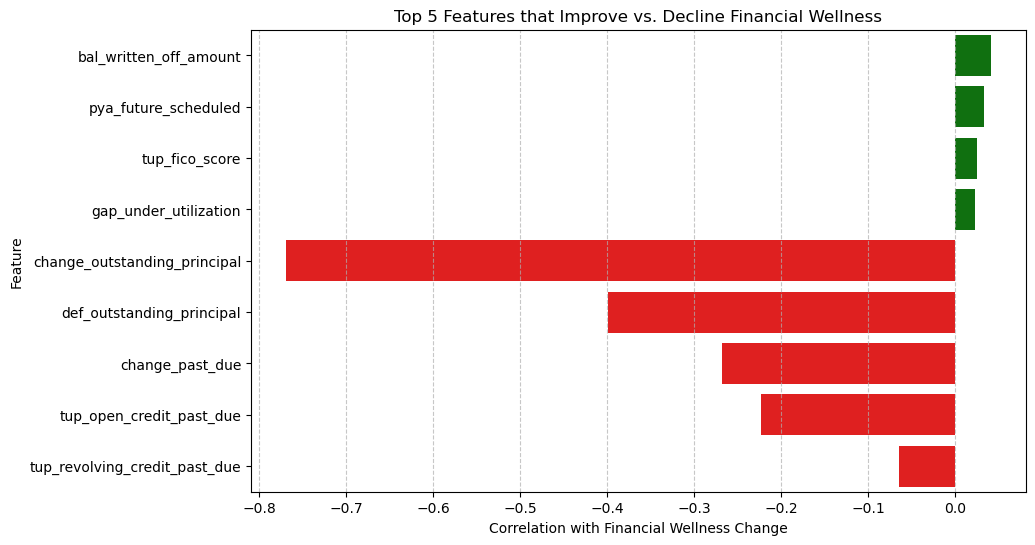

In [6]:
# Remove 'financial_wellness_change' from the data
filtered_data = feature_correlation_data.drop('financial_wellness_change', errors='ignore')

# Plot the features
plt.figure(figsize=(10, 6))
sns.barplot(
    x=filtered_data.values,
    y=filtered_data.index,
    palette=["green" if val > 0 else "red" for val in filtered_data.values]
)

plt.title("Top 5 Features that Improve vs. Decline Financial Wellness")
plt.xlabel("Correlation with Financial Wellness Change")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

## Model Building 1 (Target = Financial Wellbeing)

In [7]:
# Define your prefixes and columns to exclude
prefixes = ("pya_", "tup_", "wae_", "bal_", "gap_", "crs_", "def_")
exclude_columns = [
    "pyl_payment_initial_date", "crs_FEMALE", "pya_future_scheduled",
    "crs_resi_LIVE_FAMILY", "crs_prov_PE", "gap_user_id"
]

# Select features based on prefixes and excluding specific columns
features = [
    col for col in TSdata_clean.columns
    if col.startswith(prefixes) and col not in exclude_columns
]

# Add the target variable explicitly to the list
features.append("financial_wellness_change")

# Output the selected features for debugging
print("Selected features:", features)

# Separate features (X) and target (y)
X = TSdata_clean[features]
y = TSdata_clean["financial_wellness_change"]

# Check for missing values in features
print("Missing values in each column:\n", X.isnull().sum())

# Drop columns with excessive missing values
threshold = 0.3  # Define your missing value threshold
columns_to_drop = X.columns[X.isnull().mean() > threshold]
X = X.drop(columns=columns_to_drop)
print("Dropped columns:", columns_to_drop)

# Ensure X contains only numeric columns
X_numeric = X.select_dtypes(include=["float64", "int64"])

# Handle remaining missing values with imputation for numeric columns
imputer = SimpleImputer(strategy="mean")  # Use 'median' or 'most_frequent' if needed
X_imputed = pd.DataFrame(imputer.fit_transform(X_numeric), columns=X_numeric.columns)

# Get non-numeric columns
X_non_numeric = X.select_dtypes(exclude=["float64", "int64"])

# Encode non-numeric columns using LabelEncoder
for col in X_non_numeric.columns:
    label_encoder = LabelEncoder()
    X_non_numeric[col] = label_encoder.fit_transform(X_non_numeric[col].astype(str))

# Combine numeric and encoded non-numeric columns
X = pd.concat([X_imputed, X_non_numeric.reset_index(drop=True)], axis=1)

# Verify no missing values remain
print("Missing values after imputation:\n", X.isnull().sum())

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE only to the training data
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print class distribution before and after SMOTE
print("Original class distribution:", Counter(y_train))
print("Resampled class distribution:", Counter(y_train_resampled))

Selected features: ['pya_status', 'pya_paid_on_time', 'pya_paid_late', 'pya_missed', 'pya_paid_early', 'pya_zeroed', 'wae_financial_wellness_score', 'crs_loan_written_off', 'crs_loan_repaid', 'crs_loan_collections', 'crs_loan_active', 'crs_loan_rewrite', 'crs_loan_past_due', 'tup_fico_score', 'crs_gender', 'crs_MALE', 'crs_residential_status', 'crs_province', 'crs_prov_ON', 'crs_prov_AB', 'crs_prov_BC', 'crs_prov_MB', 'crs_prov_NF', 'crs_prov_NB', 'crs_prov_NS', 'crs_prov_SK', 'crs_resi_RENTER', 'crs_resi_LIVEW_FAMILY', 'crs_resi_HOME_OWNER', 'crs_aptitude_for_change_score', 'crs_financial_literacy_score', 'crs_self_assessments', 'def_struggling_to_pay', 'def_restructure_event', 'def_pay_holiday', 'def_deferral_event', 'crs_quiz_count', 'crs_mood_count', 'crs_inspiration_count', 'gap_goal_no_new_debt', 'gap_goal_paid_bills_on_time', 'gap_goal_paid_parachute_on_time', 'gap_under_utilization', 'gap_admin_notes', 'gap_plan_apply_savings_to_cc', 'gap_plan_auto_withdrawal', 'gap_plan_chat_b

In [8]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# Regularized Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,  # Further limit tree depth
    min_samples_split=20,  # Increase minimum samples to split
    min_samples_leaf=10,  # Increase minimum samples in leaf
    max_features="sqrt",
    class_weight="balanced",
    random_state=42
)

# Perform 5-fold cross-validation to evaluate the model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train_resampled, y_train_resampled, cv=cv, scoring="f1_macro")
print("Cross-Validation F1-Macro Scores:", cv_scores)
print("Mean F1-Macro Score:", cv_scores.mean())

# Hyperparameter Tuning with GridSearchCV
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2"],
}

grid_search = GridSearchCV(
    RandomForestClassifier(class_weight="balanced", random_state=42),
    param_grid,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

# Train the Random Forest model with the best parameters
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

Cross-Validation F1-Macro Scores: [0.99780699 0.99780615 0.99605025 0.99692778 0.99736609]
Mean F1-Macro Score: 0.9971914535709019
Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=2,
                       min_samples_split=10, random_state=42)

In [10]:
# Evaluate the model on the test set
y_pred_rf = best_rf_model.predict(X_test)
y_prob_rf = best_rf_model.predict_proba(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))


Classification Report:
              precision    recall  f1-score   support

          -1       0.78      0.93      0.85        15
           0       1.00      0.99      0.99       950
           1       0.41      0.78      0.54         9

    accuracy                           0.98       974
   macro avg       0.73      0.90      0.79       974
weighted avg       0.99      0.98      0.98       974



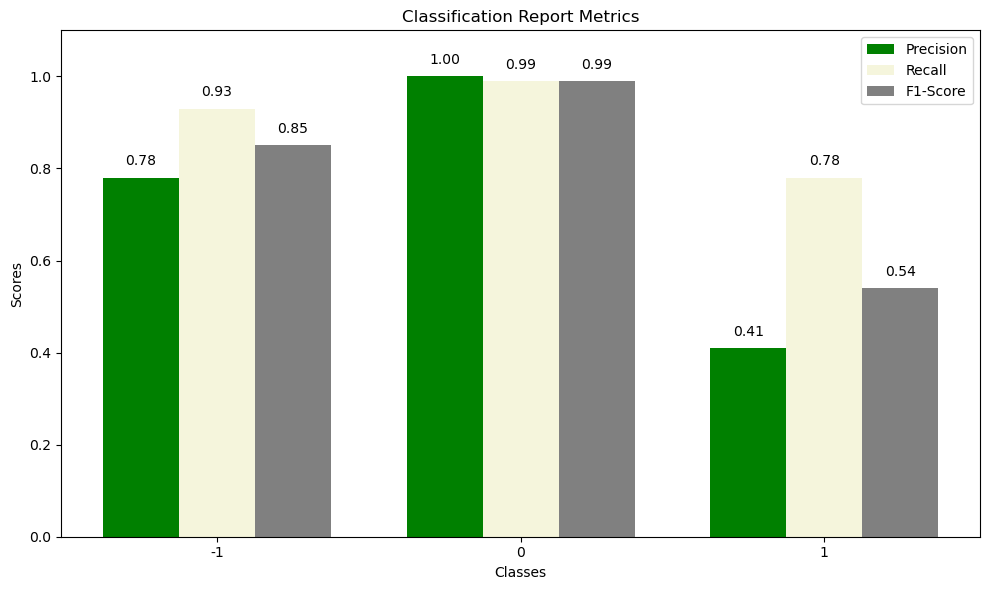

In [11]:
# Data from the classification report
categories = ['-1', '0', '1']
precision = [0.78, 1.00, 0.41]
recall = [0.93, 0.99, 0.78]
f1_score = [0.85, 0.99, 0.54]

# Setting bar width and positions
x = np.arange(len(categories))
width = 0.25

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(x - width, precision, width, label='Precision', color='green')
plt.bar(x, recall, width, label='Recall', color='beige')
plt.bar(x + width, f1_score, width, label='F1-Score', color='grey')

# Adding labels and title
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Classification Report Metrics')
plt.xticks(x, categories)
plt.ylim(0, 1.1)
plt.legend()

# Annotating bars with their values
for i in range(len(categories)):
    plt.text(x[i] - width, precision[i] + 0.02, f'{precision[i]:.2f}', ha='center', va='bottom', fontsize=10)
    plt.text(x[i], recall[i] + 0.02, f'{recall[i]:.2f}', ha='center', va='bottom', fontsize=10)
    plt.text(x[i] + width, f1_score[i] + 0.02, f'{f1_score[i]:.2f}', ha='center', va='bottom', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()

## Model Building 2 (Target = Loan Status)

In [12]:
#Client Dataset
file_path = "ParachuteClientData.xlsx"  
data = pd.read_excel(file_path, sheet_name="Sheet1")
data.columns

Index(['loanid', 'Disbursement Date', 'Loan Status', 'Loan Amount',
       'Outstanding Balance', 'Outstanding Principal', 'Interest Rate',
       'Loan Term (Months)', 'Date of Birth', 'Gender',
       'Stated Income on application', 'Qualified / Verified\nIncome',
       'Aptitude for change Score', 'Financial Literacy Score',
       'Self Assessments', 'Quiz Count', 'Mood Count', 'Inspiration Count',
       'Total Activies ', 'Average total activities per month',
       'Average activities per day', 'Province_BC', 'Province_MB',
       'Province_NB', 'Province_NFLD', 'Province_NS', 'Province_ON',
       'Province_PEI', 'Province_SK', 'Residential Status_LIVE WITH FAMILY',
       'Residential Status_RENTER', 'Residential Status_RENTING',
       'SUCCESS_no_new_debt', 'SUCCESS_paid_bills_on_time',
       'SUCCESS_under_utilization', 'SUCCESS_paid_parachute_on_time',
       'SUCCESS_paid_on_time', 'SUCCESS_Compliance', 'NumberOfTimesAssessed',
       'SR_no_new_debt', 'SR_paid_bills_on

In [13]:
#Clean Up
# Convert datetime columns to numerical (timestamps)
for col in data.select_dtypes(include=["datetime64"]).columns:
    data[col] = data[col].astype("int64") // 10**9  

# Convert boolean columns to integers
for col in data.select_dtypes(include=["bool"]).columns:
    data[col] = data[col].astype("int")



In [14]:
# Split data for model building
features = data.drop(columns=['Loan Status', 'loanid', 'Disbursement Date'])  # All columns except target

# Apply log1p only to numeric columns with non-negative values
features = features.apply(
    lambda x: np.log1p(x) if np.issubdtype(x.dtype, np.number) and (x >= 0).all() else x
)
data['Loan Status'] = data['Loan Status'].astype("category")
X_train, X_test, y_train, y_test = train_test_split(features, data['Loan Status'], test_size=0.2, random_state=42, stratify=data['Loan Status'])

In [15]:
#Model Building
rf_model = RandomForestClassifier(random_state=42)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

#Grid search to find best parameters
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_


Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [16]:
#Predict Target Values
y_pred = best_rf.predict(X_test)

#Evaluate Model
print("Best Model Parameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

#R2 Score
r2 = r2_score(y_test.cat.codes, best_rf.predict(X_test))
print("R² Score:", r2)

Best Model Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.00      0.00      0.00         1
           2       0.94      1.00      0.97        29
           3       1.00      1.00      1.00         4

    accuracy                           0.95        40
   macro avg       0.73      0.71      0.72        40
weighted avg       0.93      0.95      0.94        40

Accuracy: 0.95
R² Score: 0.8146431881371641


C:\JupyterLab\JupyterLab-desktop\jlab_server\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\JupyterLab\JupyterLab-desktop\jlab_server\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\JupyterLab\JupyterLab-desktop\jlab_server\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

C:\temp\ipykernel_308420\2726944402.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.sort_values(ascending=False)[:10], y=feature_importances.sort_values(ascending=False).index[:10], palette="viridis")


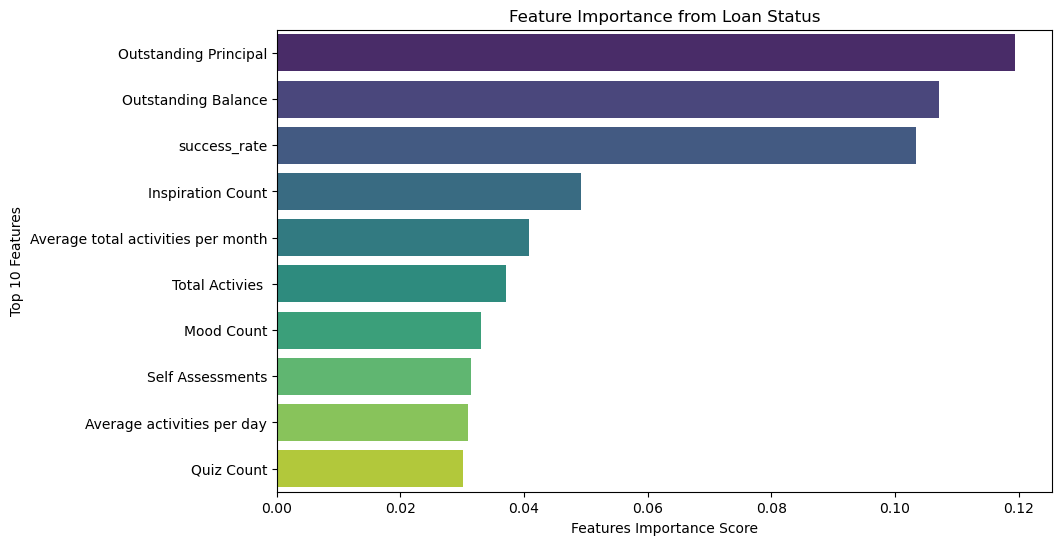

In [17]:
#Visualize Featuree importance for this model
feature_importances = pd.Series(best_rf.feature_importances_, index=features.columns)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.sort_values(ascending=False)[:10], y=feature_importances.sort_values(ascending=False).index[:10], palette="viridis")
plt.xlabel("Features Importance Score")
plt.ylabel("Top 10 Features")
plt.title("Feature Importance from Loan Status")
plt.show()

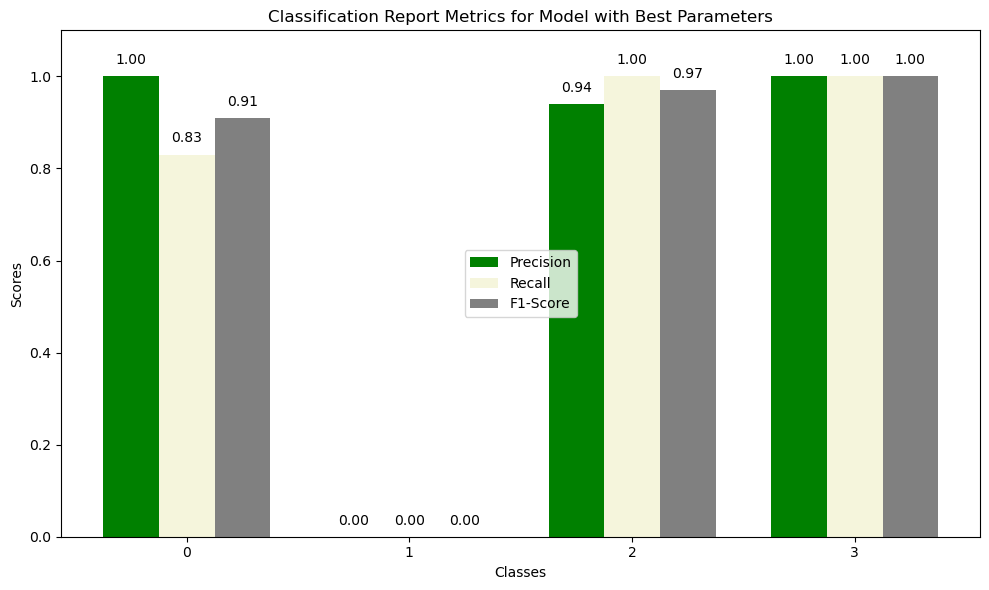

In [18]:
# Data from the new classification report
categories = ['0', '1', '2', '3']
precision = [1.00, 0.00, 0.94, 1.00]
recall = [0.83, 0.00, 1.00, 1.00]
f1_score = [0.91, 0.00, 0.97, 1.00]

# Setting bar width and positions
x = np.arange(len(categories))
width = 0.25

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(x - width, precision, width, label='Precision', color='green')
plt.bar(x, recall, width, label='Recall', color='beige')
plt.bar(x + width, f1_score, width, label='F1-Score', color='grey')

# Adding labels and title
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Classification Report Metrics for Model with Best Parameters')
plt.xticks(x, categories)
plt.ylim(0, 1.1)
plt.legend()

# Annotating bars with their values
for i in range(len(categories)):
    plt.text(x[i] - width, precision[i] + 0.02, f'{precision[i]:.2f}', ha='center', va='bottom', fontsize=10)
    plt.text(x[i], recall[i] + 0.02, f'{recall[i]:.2f}', ha='center', va='bottom', fontsize=10)
    plt.text(x[i] + width, f1_score[i] + 0.02, f'{f1_score[i]:.2f}', ha='center', va='bottom', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()

## Model Buidling 3 (Target = Compliance Success Rate)

In [19]:
# Clean Up
# Apply log transformation only to numeric features (excluding the target)
numeric_cols = data.select_dtypes(include=[np.number]).columns.drop('SR_Compliance')  # Select only numeric columns

# Apply np.log1p() only to numeric columns with non-negative values
data[numeric_cols] = data[numeric_cols].apply(
    lambda x: np.log1p(x) if (x >= 0).all() else x)


In [20]:
#Split Data
X = data.drop(columns=['SR_Compliance'])
y = data['SR_Compliance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
#Clean Up Dates
date_cols = X_train.select_dtypes(include=["datetime64"]).columns

# Convert datetime features
for col in date_cols:
    X_train[col + "_year"] = X_train[col].dt.year
    X_train[col + "_month"] = X_train[col].dt.month
    X_train[col + "_day"] = X_train[col].dt.day
    X_test[col + "_year"] = X_test[col].dt.year
    X_test[col + "_month"] = X_test[col].dt.month
    X_test[col + "_day"] = X_test[col].dt.day

# Drop the original datetime columns
X_train.drop(columns=date_cols, inplace=True)
X_test.drop(columns=date_cols, inplace=True)

#Clean Up Booleans
bool_cols = X_train.select_dtypes(include=["bool"]).columns
X_train[bool_cols] = X_train[bool_cols].astype(int)
X_test[bool_cols] = X_test[bool_cols].astype(int)

In [22]:
#Model Building
rf = RandomForestRegressor(random_state=42)

#Parameter Grid for Hyper Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
#Hypertuning
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="r2", n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [23]:
# Predict Target Variables
y_pred = best_rf.predict(X_test)

# Evaluate Regression Metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Best Parameters: {grid_search.best_params_}")
print(f"R² Score on Test Data: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Binarize the Target for Classification Report
threshold = y_train.mean()  # Adjust this threshold if needed
y_test_binary = (y_test > threshold).astype(int)
y_pred_binary = (y_pred > threshold).astype(int)

# Generate Classification Report
print("Classification Report:")
print(classification_report(y_test_binary, y_pred_binary))

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
R² Score on Test Data: 0.9263
Mean Absolute Error (MAE): 0.0379
Root Mean Squared Error (RMSE): 0.0696
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      0.95      0.98        21

    accuracy                           0.97        40
   macro avg       0.97      0.98      0.97        40
weighted avg       0.98      0.97      0.98        40



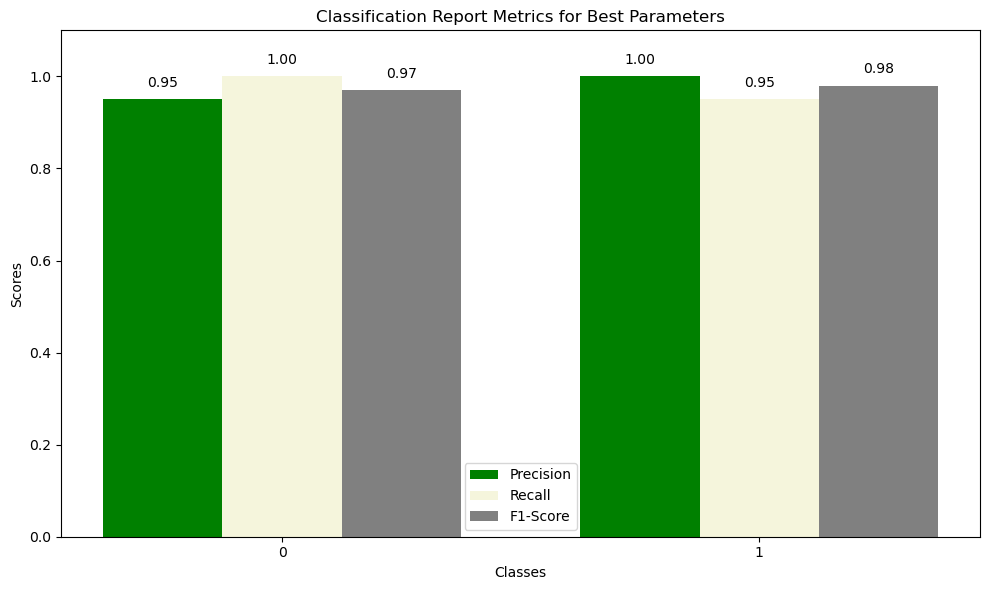

In [24]:
# Data from the classification report
categories = ['0', '1']
precision = [0.95, 1.00]
recall = [1.00, 0.95]
f1_score = [0.97, 0.98]

# Setting bar width and positions
x = np.arange(len(categories))
width = 0.25

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(x - width, precision, width, label='Precision', color='green')
plt.bar(x, recall, width, label='Recall', color='beige')
plt.bar(x + width, f1_score, width, label='F1-Score', color='grey')

# Adding labels and title
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Classification Report Metrics for Best Parameters')
plt.xticks(x, categories)
plt.ylim(0, 1.1)
plt.legend()

# Annotating bars with their values
for i in range(len(categories)):
    plt.text(x[i] - width, precision[i] + 0.02, f'{precision[i]:.2f}', ha='center', va='bottom', fontsize=10)
    plt.text(x[i], recall[i] + 0.02, f'{recall[i]:.2f}', ha='center', va='bottom', fontsize=10)
    plt.text(x[i] + width, f1_score[i] + 0.02, f'{f1_score[i]:.2f}', ha='center', va='bottom', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()

C:\temp\ipykernel_308420\3261597579.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


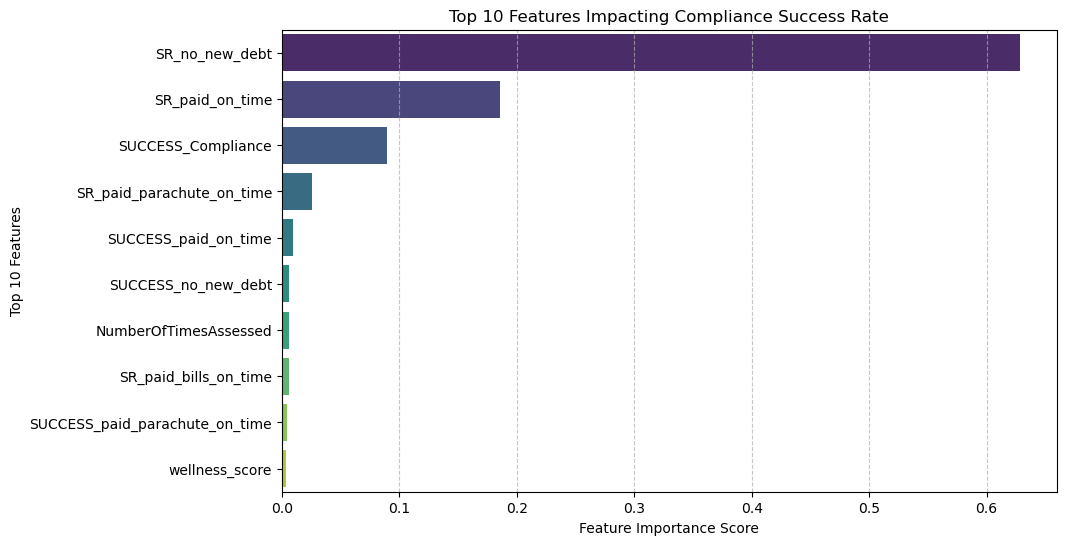

In [25]:
# Visualize Feature Importance for Compliance Success Rate
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
plt.figure(figsize=(10, 6))
sns.barplot(
    x=feature_importances.sort_values(ascending=False)[:10],
    y=feature_importances.sort_values(ascending=False).index[:10],
    palette="viridis")

plt.xlabel("Feature Importance Score")
plt.ylabel("Top 10 Features")
plt.title("Top 10 Features Impacting Compliance Success Rate")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()